In [1]:
!pip install "gym>=0.21.0"
!pip install tf-agents


In [2]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts
import os
import copy
import sys      
import time

import threading
from datetime import datetime, timedelta

import numpy as np
import matplotlib.pyplot as plt
import torch
import tensorflow as tf
#from gnuradio import gr
#import pmt
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Dense, Softmax
from tensorflow.keras.layers import Dense

from gym import Env
from gym.spaces import Discrete, Box


#from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg
#from matplotlib.figure import Figure
#from PyQt5 import QtCore #conda install pyqt
#from PyQt5 import QtWidgets

import abc
from tf_agents.networks import q_network
from tf_agents.agents.dqn import dqn_agent

import copy

In [3]:
HISTORY_BUFFER_LEN = 100
DEFAULT_WINDOW_SIZE = 3
EPISODE_LENGTH = 20
NUMBER_OF_EPISODES = 100
seed = 1


In [4]:
gpus = tf.config.experimental.list_physical_devices("GPU")
print('Number of GPUs available :', len(gpus))
num_GPU = 1        
if num_GPU < len(gpus):
  tf.config.experimental.set_visible_devices(gpus[num_GPU], 'GPU')
  tf.config.experimental.set_memory_growth(gpus[num_GPU], True)
  print('Only GPU number', num_GPU, 'used')

tf.random.set_seed(seed)

Number of GPUs available : 0


In [5]:
    
    class transmit_wait():

    	def __init__(self, sensed = 0 , window_size = DEFAULT_WINDOW_SIZE, history = 0  ):
    		self._action_spec = Discrete(11) #transmit or not {0,0.1,...,0.9,1}
    		self.initial_state = history 
    		self._state = history
    		self.window_size = window_size	
    		self.episode_length = EPISODE_LENGTH
    		self.reward = 0

    	def reset(self):
    		self._state = [self.initial_state , self.sensed , 0]
    		self._episode_ended = False
    		self.episode_length = EPISODE_LENGTH
    		self.reward = 0
    		return (self.reward , self._state , 0)

    	def step(self, action,transmit_prob , good_reward):
    		history = self._state
    		
    		if transmit_prob > action:
    			transmit = 1
    		else:
    			transmit = 0  

    		if history[-1] == 1 and transmit == 1: #collision
    			self.reward = self.reward-good_reward
    		elif history[-1] == 0 and transmit == 1: #clean transmit
    			self.reward = self.reward+2
    		elif history[-1] == 1 and transmit == 0: #avoided collision
    			self.reward = self.reward+2
    		elif history[-1] == 0 and transmit == 0: #wasted slot
    			self.reward = self.reward-1	
    		reward = self.reward	#comulative reward
    		self.reward = 0
    		return(reward)


In [6]:
class DQN_agent():
    	def __init__(self, learning_rate, gamma, window_size):
    		self.nb_actions = 11 #on off
    		self.window_size = window_size
    		self.gamma = gamma
    		self.learning_rate = learning_rate
    		
    		self.history_length = HISTORY_BUFFER_LEN
    		self.history = [[]for i in range(self.history_length)]
    		self.history_idx = 0
    		
    		#Create and initialize the online DQN
    		self.DQN_online = tf.keras.models.Sequential([Dense(self.window_size, activation='relu'),Dense(self.window_size/2, activation='relu'), Dense(self.nb_actions, activation='softplus') #Outputs positive values 
    		])
    		self.DQN_online.build(input_shape=(None, self.window_size)) #Build the model to create the weights
    		
    		#Create and initialize the offline DQN
    		self.DQN_offline = tf.keras.models.Sequential([Dense(self.window_size, activation='relu'),Dense(self.window_size/2, activation='relu'), Dense(self.nb_actions, activation='softplus') #Outputs positive values
    		])
    		self.DQN_offline.build(input_shape=(None, self.window_size)) #Build the model to create the weights
    		
    		self.copy_parameters() #Copy the weights of the online network to the offline network
    		
    		self.loss_func = tf.keras.losses.MSE
    		self.optimizer = tf.keras.optimizers.Adam(self.learning_rate)
        
        
    	def choose_action(self, state, epsilon):
    		"""Implements an epsilon-greedy policy"""
    		history = state
    		# Explore ?
    		if np.random.uniform(size=1) < epsilon :
    			action =  np.random.randint(11) 


    		#Exploite - Choose the current best action
    		else:    
    			DQN_input = tf.concat(history, axis=0)[tf.newaxis, :] #Create a state vector, which is the DQN input. Shape : [1, 1]
    			outputs = self.DQN_online(DQN_input).numpy() #Get the predicted Q values corresponding to the 2 actions
    			action = np.argmax(outputs) #Take the action that has the highest predicted Q value (0, 1)
    		return action
    
    	def learn(self, batch_size):
    		"""Sample experiences from the history and performs SGD"""
    		
    		# Samples random experiences from the history
    		idx = np.random.choice(range(self.history_length), batch_size, replace=False) # Create random indexes 
    		rdm_exp =  [self.history[i] for i in idx] # Take experiences corresponding to the random indexes
    		
    		
    		# Create 4 batches : states_vec, actions, rewards, new states_vec
    		states_vec = np.array([rdm_exp[i][0] for i in range(batch_size)]) # Shape : [Bs, 2*self.nb_ch]
    		actions = np.array([rdm_exp[i][1] for i in range(batch_size)]) # Shape : [BS]
    		rewards = np.array([rdm_exp[i][2] for i in range(batch_size)]) # Shape : [BS]
    		n_states_vec = np.array([rdm_exp[i][3] for i in range(batch_size)]) # Shape : [Bs, 2*self.nb_ch]
    		
    		#Compute the best q_value for the new states
    		max_n_q_values = tf.reduce_max(self.DQN_offline(n_states_vec), axis=1).numpy()

    		with tf.GradientTape() as tape:
    			#Forward pass through the online network to predict the q_values
    			pred_q_values = self.DQN_online(states_vec)
    			
    			# Compute targets
    			targets = pred_q_values.numpy()
    			targets[np.arange(targets.shape[0]), actions]= rewards +   self.gamma * max_n_q_values
    			
    			# Evaluate the loss
    			self.loss = self.loss_func(pred_q_values, targets)
        
    		# Compute gradients and perform the gradient descent
    		gradients = tape.gradient(self.loss, self.DQN_online.trainable_weights)
    		self.optimizer.apply_gradients(zip(gradients, self.DQN_online.trainable_weights))  
    
    	def insert_history(self, state, action, reward, n_state):
    		"""Insert experience in history"""
        
    		#sensed_ch, curr_ch, end = state
    		history = state
    		state_vec = np.array(history)# Create the state vector for the state
        
    		n_history = n_state
    		n_state_vec = np.array(n_history) # Create the state vector for the new state

    		self.history[self.history_idx] = [state_vec, action, reward, n_state_vec] # Insert everything in the history
        
    		self.history_idx = (self.history_idx+1)%self.history_length # Move the history_idx by one
    
    	def copy_parameters(self):
    		"""Copy the parameters of the online network to the offline network"""

    		weights = self.DQN_online.get_weights()
    		self.DQN_offline.set_weights(weights)			

initial step:
agent 1:  [0. 0. 0. 0.]
agent 2:  [0. 0. 0. 0.]
episodes:  0
episodes:  10
episodes:  20
episodes:  30
episodes:  40
episodes:  50
episodes:  60
episodes:  70
episodes:  80
episodes:  90
[[7.959414, 7.6087236, 7.234973, 7.347927, 7.971117, 7.271129, 6.6890564, 6.8451595, 6.164376, 6.2949977, 3.8887537, 3.6339843, 3.1099863, 7.62924, 7.5598884, 3.5348508, 6.126379, 7.2955766, 7.0661225, 5.295374, 4.4337068, 5.458728, 4.0431232, 7.4244065, 5.703873, 7.2325163, 2.9307368, 4.3111477, 6.2416363, 2.238542, 0.71737456, 2.7940054, 5.563884, 5.9790235, 7.3650465, 6.394436, 6.9483557, 2.5170846, 7.3634715, 6.117146, 5.978682, 1.5477817, 7.363949, 4.8711286, 6.9483056, 7.3637996, 3.2094522, 3.9018207, 7.086751, 1.8247272, 7.363691, 7.3637586, 0.7169448, 2.2401452, 2.5170908, 6.5328465, 7.363719, 4.871125, 7.3637047, 7.3637037, 6.5328307, 5.2865505, 5.148081, 5.286549, 3.0709817, 4.317237, 4.317238, 5.148075, 6.671298, 7.3636937, 2.794036, 1.4093089, 3.4863987, 2.5170908, 4.871137, 7

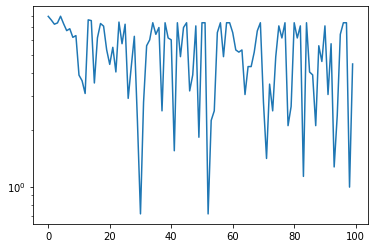

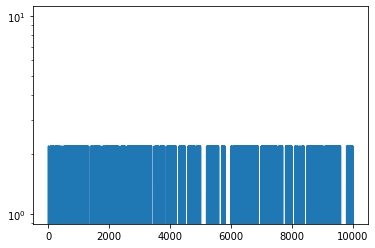

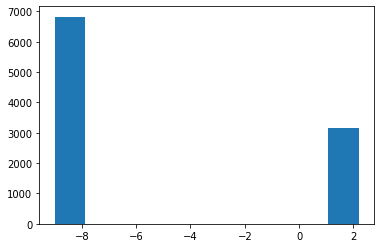

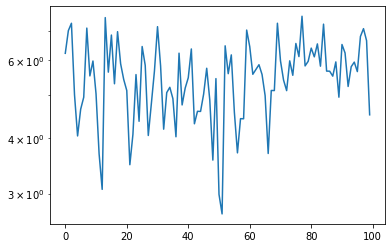

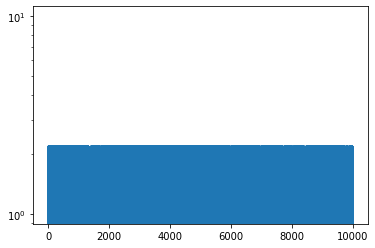

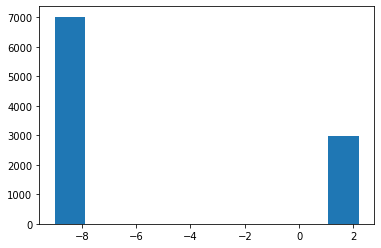

No handles with labels found to put in legend.


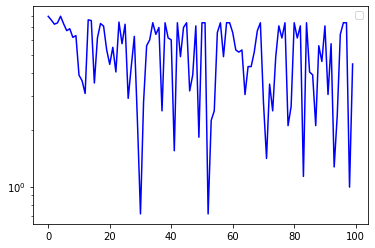

No handles with labels found to put in legend.


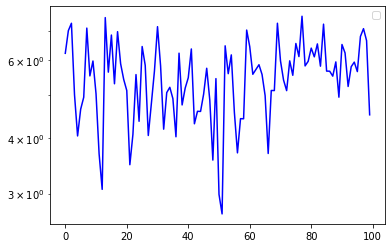

In [7]:
window_size = DEFAULT_WINDOW_SIZE
gamma = 0.2
learning_rate = 0.075
epsilon = 0.2


losses1 = []
losses2 = []
rewards1 = []
rewards2 = []
for x in range(0,1):
  good_reward = 6
  loss1 = []
  loss2 = []
  reward_coll1=[]
  reward_coll2=[]
  window_size = 4
  "Main code"
  #an agent cant hear itself when he is transmitting
  channel_agent1 = np.zeros(window_size)
  channel_agent2 = np.zeros(window_size)

  environment1 = transmit_wait(0,window_size, channel_agent1)
  environment2 = transmit_wait(0,window_size, channel_agent2)  

  #Round 1: agent draw actions without prior knowladge 
  agent1 = DQN_agent((learning_rate), (gamma), window_size) #init agent spaces
  agent2 = DQN_agent((learning_rate), (gamma), window_size) #init agent spaces

  prv_state1 = channel_agent1
  prv_state2 = channel_agent2

  #Both take a random action
  prv_action1 = agent1.choose_action(channel_agent1, 1)
  prv_transmit_prob1  = np.random.randint(11)
  if prv_action1 > prv_transmit_prob1:
    channel_agent2 = np.append(channel_agent2,1)
  else:
    channel_agent2 = np.append(channel_agent2,0)
  channel_agent2 = np.delete(channel_agent2,0)

  prv_transmit_prob2  = np.random.randint(11)
  prv_action2 = agent2.choose_action(channel_agent2, 1) 
  if prv_action2 > prv_transmit_prob2:
    channel_agent1 = np.append(channel_agent1,1)
  else:
    channel_agent1 = np.append(channel_agent1,0)
  channel_agent1 = np.delete(channel_agent1,0)

  #new state
  environment1._state = channel_agent1
  environment2._state = channel_agent2


  print('initial step:')
  print('agent 1: ', environment1._state)
  print('agent 2: ', environment2._state)

  #Fill Replay buffer - take HISTORY_BUFFER_LEN time steps
  for i in range(0,HISTORY_BUFFER_LEN):
    
    transmit_prob1  = np.random.randint(11)
    transmit_prob2  = np.random.randint(11)
    
    #Change states
    #Both take random actions (epsilon = 1)
    action1 = agent1.choose_action(environment1._state, 1)
    transmit_prob1  = np.random.randint(11)
    if action1 > transmit_prob1:
      environment2._state = np.append(environment2._state, 1)
    else:
      environment2._state  = np.append(environment2._state, 0)
    environment2._state = np.delete(environment2._state, 0)

    transmit_prob2  = np.random.randint(11)
    action2 = agent2.choose_action(environment2._state, 1) 
    if action2 > transmit_prob2:
      environment1._state = np.append(environment1._state, 1)
    else:
      environment1._state  = np.append(environment1._state, 0)
    environment1._state = np.delete(environment1._state, 0)

    reward1 = environment1.step(prv_action1, prv_transmit_prob1 , good_reward)
    reward2 = environment2.step(prv_action1, prv_transmit_prob2 , good_reward)

    agent1.insert_history(prv_state1, prv_action1, reward1, environment1._state)
    agent2.insert_history(prv_state2, prv_action2, reward2, environment2._state)
    
    #save PREVIOUS state and action
    prv_action1 = action1
    prv_action2 = action2
    prv_state1 = environment1._state
    prv_state2 = environment2._state 
    prv_transmit_prob1 = transmit_prob1
    prv_transmit_prob2 = transmit_prob2


  agent1.learn(int(HISTORY_BUFFER_LEN/2)) # Each time we store a new history, we perform a training on random data
  agent1.copy_parameters() #lower update frequency?


  agent2.learn(int(HISTORY_BUFFER_LEN/2)) # Each time we store a new history, we perform a training on random data
  agent2.copy_parameters() #lower update frequency?

  for episodes in range(0,NUMBER_OF_EPISODES):
    #Fill Replay buffer - take HISTORY_BUFFER_LEN time steps
    for i in range(0,HISTORY_BUFFER_LEN):
      
      epsilon = 0.999*epsilon
      transmit_prob1  = np.random.randint(11)
      transmit_prob2  = np.random.randint(11)
      
      #Change states
      #Both take epsilon random actions
      action1 = agent1.choose_action(environment1._state, epsilon)
      transmit_prob1  = np.random.randint(11)
      if action1 > transmit_prob1:
        environment2._state = np.append(environment2._state, 1)
      else:
        environment2._state  = np.append(environment2._state, 0)
      environment2._state = np.delete(environment2._state, 0)

      transmit_prob2  = np.random.randint(11)
      action2 = agent2.choose_action(environment2._state, epsilon) 
      if action2 > transmit_prob2:
        environment1._state = np.append(environment1._state, 1)
      else:
        environment1._state  = np.append(environment1._state, 0)
      environment1._state = np.delete(environment1._state, 0)

      reward1 = environment1.step(prv_action1, prv_transmit_prob1 , good_reward)
      reward_coll1.append(reward1)
      reward2 = environment2.step(prv_action1, prv_transmit_prob2 , good_reward)
      reward_coll2.append(reward2)
      agent1.insert_history(prv_state1, prv_action1, reward1, environment1._state)
      agent2.insert_history(prv_state2, prv_action2, reward2, environment2._state)
      
      #save PREVIOUS state and action
      prv_action1 = action1
      prv_action2 = action2
      prv_state1 = environment1._state
      prv_state2 = environment2._state 
      prv_transmit_prob1 = transmit_prob1
      prv_transmit_prob2 = transmit_prob2
    agent1.learn(int(HISTORY_BUFFER_LEN/2)) # Each time we store a new history, we perform a training on random data
    agent2.learn(int(HISTORY_BUFFER_LEN/2)) # Each time we store a new history, we perform a training on random data
    if episodes%10 == 0:
      agent1.copy_parameters()
      agent2.copy_parameters()
      print('episodes: ', episodes)
    loss1.append(tf.reduce_mean(agent1.loss).numpy()) #Save the losses for future visualization
    loss2.append(tf.reduce_mean(agent2.loss).numpy()) #Save the losses for future visualization
  
  losses1.append(loss1)
  losses2.append(loss2)
  rewards1.append(reward_coll1)
  rewards2.append(reward_coll2)
  
  print(losses1)
  print('final step:')
  print('agent 1: ', environment1._state)
  print('agent 2: ', environment2._state)
  print('randomness level:' ,epsilon)

  plt.semilogy(np.arange(len(loss1)), loss1)
  plt.show()
  plt.semilogy(np.arange(len(reward_coll1)), reward_coll1)
  plt.show()
  counts, bins = np.histogram(reward_coll1)
  plt.hist(bins[:-1], bins, weights=counts)
  plt.show()
  plt.semilogy(np.arange(len(loss2)), loss2)
  plt.show()
  plt.semilogy(np.arange(len(reward_coll2)), reward_coll2)
  plt.show()
  counts, bins = np.histogram(reward_coll2)
  plt.hist(bins[:-1], bins, weights=counts)
  plt.show()

colors = ['b' ,'r','g', 'y','c', 'm' ,'k','indigo','orange','pink']
for j in range(0,len(losses1)):
  plt.semilogy(np.arange(len(losses1[j])), losses1[j], colors[j])
plt.legend()
plt.show()

for j in range(0,len(losses2)):
  plt.semilogy(np.arange(len(losses2[j])), losses2[j], colors[j])
plt.legend()
plt.show()


In [9]:


plt.hist([rewards1[0],rewards1[1],rewards1[2],rewards1[3],rewards1[4],rewards1[5],rewards1[6],rewards1[7]],10,label=['0', '0.1','0.2', '0.3','0.4', '0.5','0.6', '0.7','0.8', '0.9','1'])
plt.legend()
plt.show()

plt.hist([rewards2[0],rewards2[1],rewards2[2],rewards2[3],rewards2[4],rewards2[5],rewards2[6],rewards2[7]],10,label=['0', '0.1','0.2', '0.3','0.4', '0.5','0.6', '0.7','0.8', '0.9','1'])
plt.legend()
plt.show()

IndexError: ignored

In [10]:
'Run more slots for statistical collection'
agent1slots = 0
agent2slots = 0
collisions = 0
agent1clean = 0
agent2clean = 0
wasted = 0
slots = 0
for runs in range(0,1000):
  #Fill Replay buffer - take HISTORY_BUFFER_LEN time steps
  for i in range(0,HISTORY_BUFFER_LEN):
    
    epsilon = 0.99*epsilon
    transmit_prob1  = np.random.randint(11)
    transmit_prob2  = np.random.randint(11)

    #Change states
    #Both take  random actions
    action1 = agent1.choose_action(environment1._state, 1)
    transmit_prob1  = np.random.randint(11)
    if action1 > transmit_prob1:
      environment2._state = np.append(environment2._state,1)
      agent1slots += 1
      agent1transmit = 1
    else:
      environment2._state = np.append(environment2._state,0)
      agent1transmit = 0
    environment2._state = np.delete(environment2._state,0)
    

    transmit_prob2  = np.random.randint(11)
    action2 = agent2.choose_action(environment2._state, 1) 
    if action2 > transmit_prob2:
      environment1._state = np.append(environment1._state,1)
      agent2slots += 1
      agent2transmit = 1
    else:
      environment1._state = np.append(environment1._state,0)
      agent2transmit = 0
    environment1._state = np.delete(environment1._state,0)

    reward1 = environment1.step(prv_action1, prv_transmit_prob1 , good_reward)
    reward2 = environment2.step(prv_action1, prv_transmit_prob2 , good_reward)

    agent1.insert_history(prv_state1, prv_action1, reward1, environment1._state)
    agent2.insert_history(prv_state2, prv_action2, reward2, environment2._state)
    
    if agent1transmit == 1 and agent2transmit == 1:
      collisions += 1
    if agent1transmit == 0 and agent2transmit == 1:
      agent2clean += 1
    if agent1transmit == 1 and agent2transmit == 0:
      agent1clean += 1
    if agent1transmit == 0 and agent2transmit == 0:
      wasted += 1
    #save PREVIOUS state and action
    prv_action1 = action1
    prv_action2 = action2
    prv_state1 = environment1._state
    prv_state2 = environment2._state
    prv_transmit_prob1 = transmit_prob1
    prv_transmit_prob2 = transmit_prob2
    slots += 1
  agent1.learn(int(HISTORY_BUFFER_LEN/2)) # Each time we store a new history, we perform a training on random data
  agent2.learn(int(HISTORY_BUFFER_LEN/2)) # Each time we store a new history, we perform a training on random data
  if runs%10 == 0:
    agent1.copy_parameters()
    agent2.copy_parameters()
    print('episode: ', runs)

print('total time slots: ', slots)
print('agent 1 all transmit slots:', agent1slots)
print('agent 2 all transmit slots:', agent2slots)
print('Collisions: ', collisions)
print('agent 1 clean slots: ', agent1clean)
print('agent 2 clean slots: ', agent2clean)
print('wasted slots: ', wasted)

episode:  0
episode:  10
episode:  20
episode:  30
episode:  40
episode:  50
episode:  60
episode:  70
episode:  80
episode:  90
episode:  100
episode:  110
episode:  120
episode:  130
episode:  140
episode:  150
episode:  160
episode:  170
episode:  180
episode:  190
episode:  200
episode:  210
episode:  220
episode:  230
episode:  240
episode:  250
episode:  260
episode:  270
episode:  280
episode:  290
episode:  300
episode:  310
episode:  320
episode:  330
episode:  340
episode:  350
episode:  360
episode:  370
episode:  380
episode:  390
episode:  400
episode:  410
episode:  420
episode:  430
episode:  440
episode:  450
episode:  460
episode:  470
episode:  480
episode:  490
episode:  500
episode:  510
episode:  520
episode:  530
episode:  540
episode:  550
episode:  560
episode:  570
episode:  580
episode:  590
episode:  600
episode:  610
episode:  620
episode:  630
episode:  640
episode:  650
episode:  660
episode:  670
episode:  680
episode:  690
episode:  700
episode:  710
epi